### Imports

In [3]:
# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns

In [4]:
# File Management Libraries
import xml.etree.ElementTree as ET
import glob
import os
from pathlib import Path

In [6]:
# Object anda Data Structure Management Libraries
from PIL import Image
import pandas as pd
import numpy as np

In [7]:
# Read the extracted file(s) using pandas
#df = pd.read_csv('data/stanford_dogs.csv')  # Adjust the file extension and path as per your extracted file
# Now you can work with the DataFrame (df) as needed
# For example, you can print the first few rows

### Preprocessing

In [38]:
######## Read X and Y coordinate ranges from an annotation ########
def get_bbox(annot):
    root = ET.parse(annot).getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

In [33]:
def get_image_path(annot):
    img_path = 'data/Images/'
    file = annot.replace('\\','/').split('/')
    img_filename = img_path + file[-2] + '/' + file[-1] + '.jpg'
    return img_filename

In [56]:
def get_dog_breed(annot):
    file = annot.replace('\\','/').split('/')
    return file[-2].split('-')[1]

In [54]:
print(annotations[0])
get_image_path(annotations[0])

data/Annotation\n02085620-Chihuahua\n02085620_10074


'data/Images/n02085620-Chihuahua/n02085620_10074.jpg'

In [44]:
dog_image_paths = np.array(glob.glob('data/Images/*/*'))
annotations = np.array(glob.glob('data/Annotation/*/*'))
print(get_bbox(annotations[0]))

[(25, 10, 276, 498)]


In [47]:
annotations

array(['data/Annotation\\n02085620-Chihuahua\\n02085620_10074',
       'data/Annotation\\n02085620-Chihuahua\\n02085620_10131',
       'data/Annotation\\n02085620-Chihuahua\\n02085620_10621', ...,
       'data/Annotation\\n02116738-African_hunting_dog\\n02116738_9829',
       'data/Annotation\\n02116738-African_hunting_dog\\n02116738_9844',
       'data/Annotation\\n02116738-African_hunting_dog\\n02116738_9924'],
      dtype='<U72')

In [35]:
for i in range(8):
    print(get_bbox(annotations[i]))

[(25, 10, 276, 498)]
[(49, 9, 393, 493)]
[(142, 43, 335, 250)]
[(0, 27, 312, 498)]
[(90, 104, 242, 452)]
[(17, 38, 451, 253)]
[(39, 191, 145, 383)]
[(76, 30, 363, 375)]


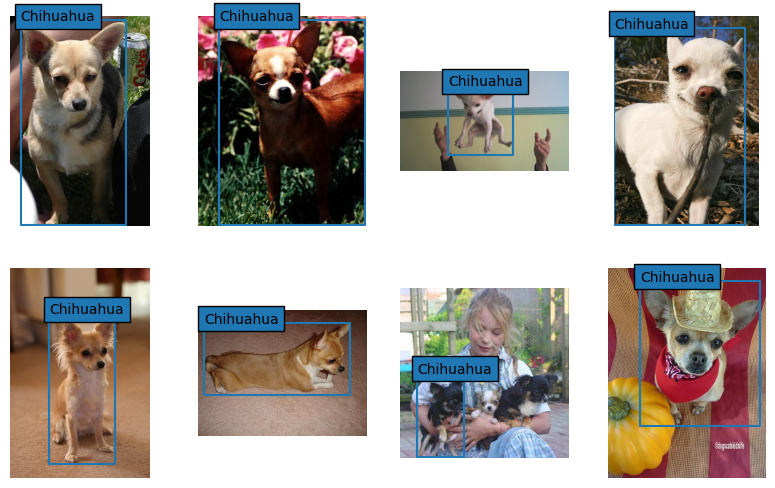

In [58]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2, 4, i+1)

    bbox = get_bbox(annotations[i])

    plt.axis("off")
    dog = get_image_path(annotations[i])
    im = Image.open(dog)
    #im = im.resize((256,256), Image.ANTIALIAS)
    plt.imshow(im)
    
    for j in range(len(bbox)):
        xmin, ymin, xmax, ymax = bbox[j]
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, get_dog_breed(annotations[i]), bbox={'ec': None})

In [ ]:
plt.figure(figsize=(10,6))
for i in range(len(dog_image_paths)):
    bbox = get_bbox(annotations[i])
    dog = get_image_path(annotations[i])
    im = Image.open(dog)
    for j in range(len(bbox)):
        im2 = im.crop(bbox[j])
        #im2 = im2.resize((331,331), Image.ANTIALIAS)
        new_path = dog.replace('data/Images/','data/Cropped/')
        new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
        im2 = im2.convert('RGB')
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im2.save(new_path)

### Train Test Split

### Model Defintion

### Model Training

In [ ]:
num_layers = 4
d_model = 128
dff = 2048
num_heads = 8
dropout_rate = 0.4
epochs = 50
num_classes = df.Grade.nunique()
global_batch = 256

### Training Plots

In [ ]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

In [ ]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [ ]:
learning_rate = CustomSchedule(d_model)
lr = np.array([])
for i in range(1, 17000):
    lr = np.append(lr, learning_rate.__call__(i))
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
#plt.axis([0, 300, 0, 0.000125])
plt.legend()

### Model Evaluation

In [ ]:
pred = model.predict(X_test)

In [ ]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))

normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))

In [ ]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

In [ ]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)